In [16]:
import os, sys, time, torch, random, argparse, json, datetime, pickle, itertools
from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.distributions import Categorical
from typing import Type, Any, Callable, Union, List, Optional
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
from model_dict import get_model_from_name
from utils import get_model_infos
from log_utils import AverageMeter, ProgressMeter, time_string, convert_secs2time
from starts import prepare_logger
from get_dataset_with_transform import get_datasets
from DiSK import obtain_accuracy, get_mlr, save_checkpoint
from models import *

In [17]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.set_num_threads(8)
train_data, valid_data, xshape, class_num = get_datasets(
    'cifar100', '/home/prathamesh/code/data/cifar/', 16
)
print("train:{}, valid:{}".format(len(train_data), len(valid_data)))
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=1000,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)
valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=1000,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)
rand_seed = 5
random.seed(rand_seed)
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
torch.cuda.manual_seed(rand_seed)
torch.cuda.manual_seed_all(rand_seed)

Files already downloaded and verified
Files already downloaded and verified
train:50000, valid:10000


In [15]:
print(class_num, xshape)
model = ResNet10_l(class_num, adaptive_pool=False).cuda()

100 (1, 3, 32, 32)


In [16]:
teacher = model
checkpoint = torch.load("/home/shashank/disk/model_10l/disk-CE-cifar100-ResNet10_l-model_best.pth.tar")
teacher.load_state_dict(checkpoint['base_state_dict'])

<All keys matched successfully>

In [20]:
!gpustat
teacher.training

know-distill              Wed Apr 26 14:54:52 2023  510.47.03
[0] NVIDIA A100-SXM4-40GB | 29°C,   0 % |  3191 / 40960 MB | anmolreddy(2583M)


False

In [31]:
criterion = nn.CrossEntropyLoss(reduction='none').cuda()
teacher.train()
valid_loss, valid_acc1, valid_acc5 = evaluate_model(teacher, valid_loader, criterion, 400)
print(
    "***{:s}*** [Teacher] EVALUATION loss = {:.6f}, accuracy@1 = {:.2f}, accuracy@5 = {:.2f}, error@1 = {:.2f}, error@5 = {:.2f}".format(
        time_string(),
        valid_loss,
        valid_acc1,
        valid_acc5,
        100 - valid_acc1,
        100 - valid_acc5,
    )
)

***[2023-04-26 15:07:41]*** [Teacher] EVALUATION loss = 0.916436, accuracy@1 = 73.72, accuracy@5 = 93.84, error@1 = 26.28, error@5 = 6.16


In [18]:
def evaluate_model( network, xloader, criterion, batch_size ):
    losses, top1, top5 = ( AverageMeter(), AverageMeter(), AverageMeter(),)
    network.eval()

    for i, (inputs, targets) in enumerate(xloader):

        inputs = inputs.cuda()
        targets = targets.cuda(non_blocking=True)
        features, logits, _ = network(inputs)

        loss = criterion(logits, targets)
        
        prec1, prec5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))

        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        top5.update(prec5.item(), inputs.size(0))

    return losses.avg, top1.avg, top5.avg

In [21]:
model = ResNet10_s(class_num, adaptive_pool=False).cuda()
student = model
checkpoint = torch.load("./trained/DiSK_seed-1_cycles-4_T-4_cifar100-ResNet10_smodel_best.pth.tar")
student.load_state_dict(checkpoint['base_state_dict'])
criterion = nn.CrossEntropyLoss().cuda()
student.train()
valid_loss, valid_acc1, valid_acc5 = evaluate_model(student, valid_loader, criterion, 400)
print(
    "***{:s}*** [student] test loss = {:.6f}, accuracy@1 = {:.2f}, accuracy@5 = {:.2f}, error@1 = {:.2f}, error@5 = {:.2f}".format(
        time_string(),
        valid_loss,
        valid_acc1,
        valid_acc5,
        100 - valid_acc1,
        100 - valid_acc5,
    )
)

***[2023-05-10 06:37:38]*** [student] test loss = 4.654458, accuracy@1 = 56.49, accuracy@5 = 84.79, error@1 = 43.51, error@5 = 15.21


In [ ]:
with open('./meta_results/meta_half_seed-1_metalr-0.0001_T-2_400_4-cycles/alpha_dump.pkl', 'rb') as f:
    vectors = pickle.load(f)

In [15]:
print(vectors[0][:10])
num_figs = len(vectors)
num_plots = num_figs//9+1
print(len(vectors))

tensor([-0.6837, -0.6891, -0.6856, -0.6819, -0.6890, -0.6904, -0.6934, -0.7004,
        -0.6865, -0.6845])
21


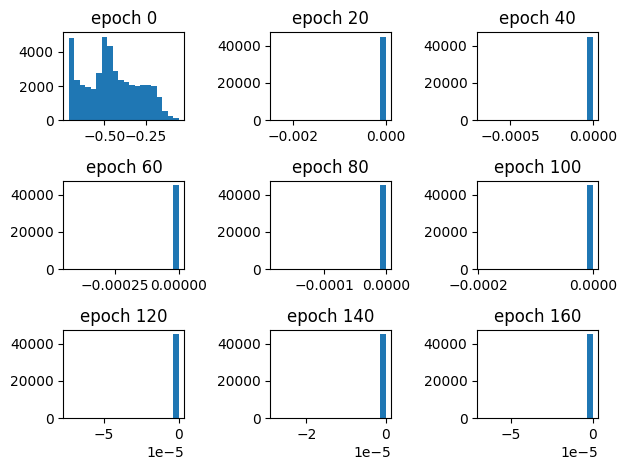

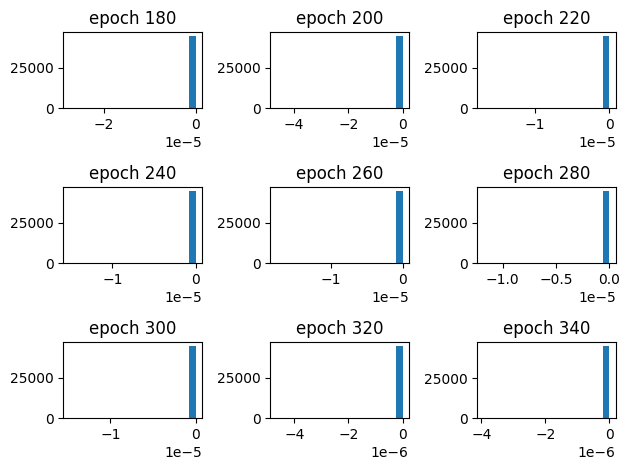

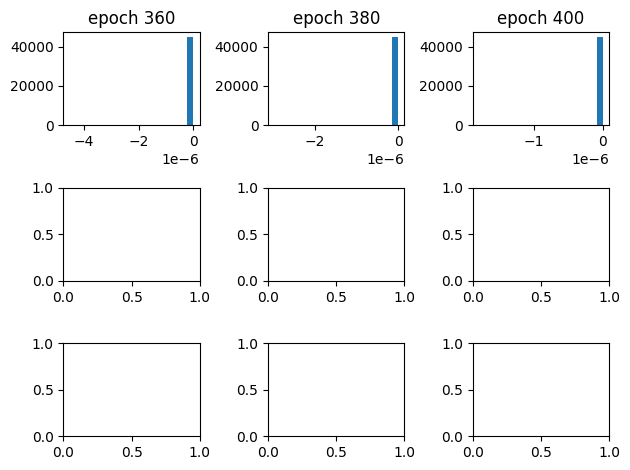

In [14]:
for i in range(num_plots):
    fig, axs = plt.subplots(3, 3)
    axs = axs.flatten()
    for j in range(9):
        index = i*9+j
        if index == num_figs:
            break
        axs[j].hist(vectors[index], bins=20)
        axs[j].set_title(f"epoch {index*20}")
    fig.tight_layout()
    fig.savefig("./meta_results/meta_half_seed-1_metalr-0.0001_T-2_5_4-cycles/"\
                "log_histograms_{}.png".format(i))
    

#

In [4]:

# Certainly! If you have two tensors of size Bxk and you want to compute the KL divergence for each row independently, you can use PyTorch's broadcasting feature. Here's an updated code snippet:

# python
# Copy code
import torch
import torch.nn.functional as F

# Assuming y_n and x_n are tensors of size Bxk
y_n = torch.tensor([[0.5, 0.3, 0.2], [0.7, 0.2, 0.1]])  # Example values
x_n = torch.tensor([[0.4, 0.3, 0.3], [0.6, 0.3, 0.1]])  # Example values

# Compute the KL divergence for each row independently
kl_div = (y_n * (torch.log(y_n) - torch.log(x_n))).sum(dim=1)

print(kl_div)  # Print the result

tensor([0.0305, 0.0268])
